**GROUP 12:** <br>
- Pedro Cerejeira (20230442) <br>

<hr>
<a class="anchor" id="import">
    
# 0. Next Steps
    
</a>

**I should try:
Correlation check
Feature Selection (best features)**

<hr>
<a class="anchor" id="import">
    
# 1. Import
    
</a>

<a class="anchor" id="importlibraries">

## 1.1. Import Libraries

</a>

In [3]:
# Import Packages
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Seeting seaborn style
sns.set(style="darkgrid")

# Setting display options to show all columns
pd.set_option('display.max_columns', None)

<a class="anchor" id="importdatasets">

## 1.1. Import Datasets

</a>

In [4]:
init_train = pd.read_csv("train.csv")
init_test = pd.read_csv("test.csv")

<hr>
<a class="anchor" id="import">
    
# 1. Dataset Exploration
    
</a>

In [5]:
df = init_train.copy()
df_test = init_test.copy()

In [6]:
encounter_ids = df_test['encounter_id']

In [7]:
df.drop(columns=(['country', 'patient_id', 'encounter_id']), inplace=True)
df_test.drop(columns=(['country', 'patient_id', 'encounter_id']), inplace=True)

In [8]:
df["discharge_disposition"].value_counts()

Discharged to home                                                                                           42256
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9005
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1393
Expired                                                                                                       1135
Discharged/transferred to another type of inpatient care institution                                           822
Not Mapped                                                                                                     679
Discharged/transferred to ICF                                                   

In [9]:
excluded_dispositions = [
    'Hospice / home', 
    'Expired', 
    'Hospice / medical facility', 
    'Expired at home. Medicaid only, hospice.', 
    'Expired in a medical facility. Medicaid only, hospice.'
]

filter_condition = ~df['discharge_disposition'].isin(excluded_dispositions)
print(len(df))
df = df[filter_condition]
print(len(df))

#filter_condition2 = ~df_test['discharge_disposition'].isin(excluded_dispositions)
#df_test = df_test[filter_condition2]

71236
69575


In [10]:
df["discharge_disposition"].value_counts()

Discharged to home                                                                                           42256
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9005
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1393
Discharged/transferred to another type of inpatient care institution                                           822
Not Mapped                                                                                                     679
Discharged/transferred to ICF                                                                                  571
Left AMA                                                                        

In [11]:
df['OUTPUT_LABEL'] = (df.readmitted_binary == 'Yes').astype('int')

In [12]:
df["OUTPUT_LABEL"]

0        0
1        0
2        0
3        0
4        0
        ..
71231    0
71232    0
71233    1
71234    0
71235    0
Name: OUTPUT_LABEL, Length: 69575, dtype: int32

In [13]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

print('Prevalence:%.3f'%calc_prevalence(df['OUTPUT_LABEL'].values))

Prevalence:0.114


In [14]:
print('Number of columns:',len(df.columns))

Number of columns: 29


<hr>
<a class="anchor" id="import">
    
# 2. Feature Engineering
    
</a>

In [15]:
# replace ? with nan
df = df.replace('?',np.nan)

df_test = df_test.replace('?',np.nan)

<hr>
<a class="anchor" id="import">
    
# 3. Numerical Features
    
</a>

In [16]:
cols_num = ['length_of_stay_in_hospital','non_lab_procedures', 'number_of_medications',
       'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year','number_diagnoses']

cols_num_test = ['length_of_stay_in_hospital','non_lab_procedures', 'number_of_medications',
       'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year','number_diagnoses']

In [17]:
df.columns

Index(['race', 'gender', 'age', 'weight', 'payer_code',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'OUTPUT_LABEL'],
      dtype='object')

In [18]:
df[cols_num].isnull().sum()

length_of_stay_in_hospital            0
non_lab_procedures                    0
number_of_medications                 0
outpatient_visits_in_previous_year    0
emergency_visits_in_previous_year     0
inpatient_visits_in_previous_year     0
number_diagnoses                      0
dtype: int64

<hr>
<a class="anchor" id="import">
    
# 4. Categorical Features
    
</a>

In [19]:
cols_cat = ['race', 'gender', 
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'payer_code']

In [20]:
df.columns

Index(['race', 'gender', 'age', 'weight', 'payer_code',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'OUTPUT_LABEL'],
      dtype='object')

In [21]:
df[cols_cat].isnull().sum()

race                                      4968
gender                                       0
glucose_test_result                      66008
a1c_test_result                          57792
change_in_meds_during_hospitalization        0
prescribed_diabetes_meds                     0
payer_code                               27623
dtype: int64

In [22]:
df['race'] = df['race'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['glucose_test_result'] = df['glucose_test_result'].fillna('UNK')
df['a1c_test_result'] = df['a1c_test_result'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

df_test['race'] = df_test['race'].fillna('UNK')
df_test['payer_code'] = df_test['payer_code'].fillna('UNK')
df_test['glucose_test_result'] = df_test['glucose_test_result'].fillna('UNK')
df_test['a1c_test_result'] = df_test['a1c_test_result'].fillna('UNK')
df_test['medical_specialty'] = df_test['medical_specialty'].fillna('UNK')

In [23]:
print('Number medical specialty:', df.medical_specialty.nunique())
df.groupby('medical_specialty').size().sort_values(ascending = False)[0:10]

Number medical specialty: 69


medical_specialty
UNK                           33996
InternalMedicine              10027
Emergency/Trauma               5218
Family/GeneralPractice         5092
Cardiology                     3664
Surgery-General                2117
Nephrology                     1082
Orthopedics                     947
Orthopedics-Reconstructive      866
Radiologist                     805
dtype: int64

In [24]:
print('Number medical specialty:', df_test.medical_specialty.nunique())
df_test.groupby('medical_specialty').size().sort_values(ascending = False)[0:10]

Number medical specialty: 65


medical_specialty
UNK                           15027
InternalMedicine               4343
Emergency/Trauma               2246
Family/GeneralPractice         2223
Cardiology                     1636
Surgery-General                 955
Nephrology                      477
Orthopedics                     446
Orthopedics-Reconstructive      366
Radiologist                     323
dtype: int64

In [25]:
top_10 = ['InternalMedicine','Emergency/Trauma','Family/GeneralPractice',\
          'Cardiology', 'Surgery-General','Nephrology',\
          'Orthopedics','Orthopedics-Reconstructive',\
          'Radiologist','UNK']

# make a new column with duplicated data
df['med_spec'] = df['medical_specialty'].copy()
df_test['med_spec'] = df_test['medical_specialty'].copy()


# replace all specialties not in top 10 with 'Other' category
df.loc[~df.med_spec.isin(top_10),'med_spec'] = 'Other'

df_test.loc[~df_test.med_spec.isin(top_10),'med_spec'] = 'Other'

In [26]:
df.groupby('med_spec').size()

med_spec
Cardiology                     3664
Emergency/Trauma               5218
Family/GeneralPractice         5092
InternalMedicine              10027
Nephrology                     1082
Orthopedics                     947
Orthopedics-Reconstructive      866
Other                          5761
Radiologist                     805
Surgery-General                2117
UNK                           33996
dtype: int64

To convert our categorical features to numbers, we will use a technique called one-hot encoding. In one-hot encoding, you create a new column for each unique value in that column. Then the value of the column is 1 if the sample has that unique value or 0 otherwise. For example, for the column race, we would create new columns ('race_Caucasian','race_AfricanAmerican', etc). If the patient's race is Caucasian, the patient gets a 1 under 'race_Caucasian' and 0 under the rest of the race columns. To create these one-hot encoding columns, we can use the get_dummies function.

In [27]:
cols_cat_num = ['admission_type', 'discharge_disposition', 'admission_source']

df[cols_cat_num]

admission_type                              discharge_disposition  \
0          Emergency                                 Discharged to home   
1          Emergency  Discharged/transferred to a federal health car...   
2                NaN                                 Discharged to home   
3          Emergency                                 Discharged to home   
4           Elective  Discharged/transferred to home with home healt...   
...              ...                                                ...   
71231       Elective                                 Discharged to home   
71232         Urgent                                                NaN   
71233            NaN                                         Not Mapped   
71234      Emergency                      Discharged/transferred to SNF   
71235         Urgent                                 Discharged to home   

                                  admission_source  
0                                   Emergency Room  
1                                  Clinic Referral  
2                                              NaN  
3       Transfer from another health care facility  
4                               Physician Referral  
...                                            ...  
71231                           Physician Referral  
71232                           Physician Referral  
71233                                          NaN  
71234                               Emergency Room  
71235                               Emergency Room  

[69575 rows x 3 columns]

In [28]:
df.columns

Index(['race', 'gender', 'age', 'weight', 'payer_code',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'OUTPUT_LABEL', 'med_spec'],
      dtype='object')

In [29]:
df.corr()

outpatient_visits_in_previous_year  \
outpatient_visits_in_previous_year                            1.000000   
emergency_visits_in_previous_year                             0.089550   
inpatient_visits_in_previous_year                             0.104101   
average_pulse_bpm                                             0.004604   
length_of_stay_in_hospital                                   -0.007232   
number_lab_tests                                             -0.006483   
non_lab_procedures                                           -0.022439   
number_of_medications                                         0.045087   
number_diagnoses                                              0.093390   
OUTPUT_LABEL                                                  0.018680   

                                    emergency_visits_in_previous_year  \
outpatient_visits_in_previous_year                           0.089550   
emergency_visits_in_previous_year                            1.000000   
inpatient_visits_in_previous_year                            0.272892   
average_pulse_bpm                                           -0.007509   
length_of_stay_in_hospital                                  -0.009166   
number_lab_tests                                             0.003298   
non_lab_procedures                                          -0.036948   
number_of_medications                                        0.016721   
number_diagnoses                                             0.057758   
OUTPUT_LABEL                                                 0.059521   

                                    inpatient_visits_in_previous_year  \
outpatient_visits_in_previous_year                           0.104101   
emergency_visits_in_previous_year                            0.272892   
inpatient_visits_in_previous_year                            1.000000   
average_pulse_bpm                                            0.000236   
length_of_stay_in_hospital                                   0.075822   
number_lab_tests                                             0.043589   
non_lab_procedures                                          -0.066390   
number_of_medications                                        0.067688   
number_diagnoses                                             0.108393   
OUTPUT_LABEL                                                 0.169676   

                                    average_pulse_bpm  \
outpatient_visits_in_previous_year           0.004604   
emergency_visits_in_previous_year           -0.007509   
inpatient_visits_in_previous_year            0.000236   
average_pulse_bpm                            1.000000   
length_of_stay_in_hospital                   0.003018   
number_lab_tests                             0.000897   
non_lab_procedures                          -0.002366   
number_of_medications                        0.000934   
number_diagnoses                            -0.000223   
OUTPUT_LABEL                                 0.000217   

                                    length_of_stay_in_hospital  \
outpatient_visits_in_previous_year                   -0.007232   
emergency_visits_in_previous_year                    -0.009166   
inpatient_visits_in_previous_year                     0.075822   
average_pulse_bpm                                     0.003018   
length_of_stay_in_hospital                            1.000000   
number_lab_tests                                      0.317160   
non_lab_procedures                                    0.191066   
number_of_medications                                 0.462183   
number_diagnoses                                      0.220722   
OUTPUT_LABEL                                          0.043308   

                                    number_lab_tests  non_lab_procedures  \
outpatient_visits_in_previous_year         -0.006483           -0.022439   
emergency_visits_in_previous_year           0.003298           -0.036948   
inpatient_visits_in_previous_y

In [30]:
# index or score that calculates the number of comorbid conditions a patient has based on the primary, secondary, and additional diagnosis fields. Patients with higher comorbidity scores may be more likely to be readmitted.
df['comorbidity_index'] = df[['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']].notnull().sum(axis=1)
df_test['comorbidity_index'] = df_test[['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']].notnull().sum(axis=1)

df['comorbidity_index'].value_counts()

3    68498
2      873
1      204
Name: comorbidity_index, dtype: int64

In [31]:
# Combine 'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', and 'inpatient_visits_in_previous_year' to get the total number of visits in the previous year.
df['total_visits_previous_year'] = df['outpatient_visits_in_previous_year'] + df['emergency_visits_in_previous_year'] + df['inpatient_visits_in_previous_year']
df_test['total_visits_previous_year'] = df_test['outpatient_visits_in_previous_year'] + df_test['emergency_visits_in_previous_year'] + df_test['inpatient_visits_in_previous_year']
df['total_visits_previous_year'].value_counts()

0     38196
1     13701
2      6858
3      3972
4      2409
5      1384
6       897
7       613
8       388
9       289
10      180
11      170
12      104
15       68
13       66
14       64
16       46
17       45
18       22
19       18
20       12
22       10
21        9
27        7
25        5
24        5
35        5
26        4
36        4
29        3
30        3
37        2
38        2
32        2
28        2
23        1
41        1
31        1
34        1
42        1
33        1
40        1
49        1
80        1
68        1
Name: total_visits_previous_year, dtype: int64

In [32]:
# Ratio of the type of visits (e.g., ratio of emergency visits to total visits). This can help in understanding which kind of visits are more frequent for a patient.
df['emergency_to_total_visits_ratio'] = df['emergency_visits_in_previous_year'] // df['total_visits_previous_year']
df_test['emergency_to_total_visits_ratio'] = df_test['emergency_visits_in_previous_year'] // df_test['total_visits_previous_year']

df['emergency_to_total_visits_ratio'] = df['emergency_to_total_visits_ratio'].fillna(0)
df_test['emergency_to_total_visits_ratio'] = df_test['emergency_to_total_visits_ratio'].fillna(0)
df['emergency_to_total_visits_ratio'].value_counts()

0.0    67322
1.0     2253
Name: emergency_to_total_visits_ratio, dtype: int64

In [33]:
# Ratio of 'number_of_medications' to 'length_of_stay_in_hospital'. This can help understand how intensively a patient was medicated during their stay.
df['average_meds_per_day'] = df['number_of_medications'] // df['length_of_stay_in_hospital']
df_test['average_meds_per_day'] = df_test['number_of_medications'] // df_test['length_of_stay_in_hospital']
df['average_meds_per_day'].value_counts()

2     12880
3     12283
4      9383
1      7460
5      6802
6      4871
7      3454
8      2567
9      1862
10     1413
11     1084
0       889
12      885
13      775
14      579
15      486
16      405
17      335
18      242
19      198
20      163
21      124
22      108
23       90
24       62
25       45
26       30
27       21
28       18
29       15
31        9
32        9
33        8
30        6
34        5
37        2
35        2
40        1
36        1
38        1
42        1
41        1
Name: average_meds_per_day, dtype: int64

In [34]:
# Combine the 'number_lab_tests', 'non_lab_procedures', and 'number_of_medications' to create a score that measures the complexity of the patient's case or treatment.
df['complexity_score'] = df['number_lab_tests'] + df['non_lab_procedures'] + df['number_of_medications']
df_test['complexity_score'] = df_test['number_lab_tests'] + df_test['non_lab_procedures'] + df_test['number_of_medications']
df['complexity_score'].value_counts()

59     1316
60     1313
62     1310
63     1305
57     1291
       ... 
154       2
150       2
160       1
155       1
170       1
Name: complexity_score, Length: 158, dtype: int64

# CHECK CORRELATION OF NEW VARS

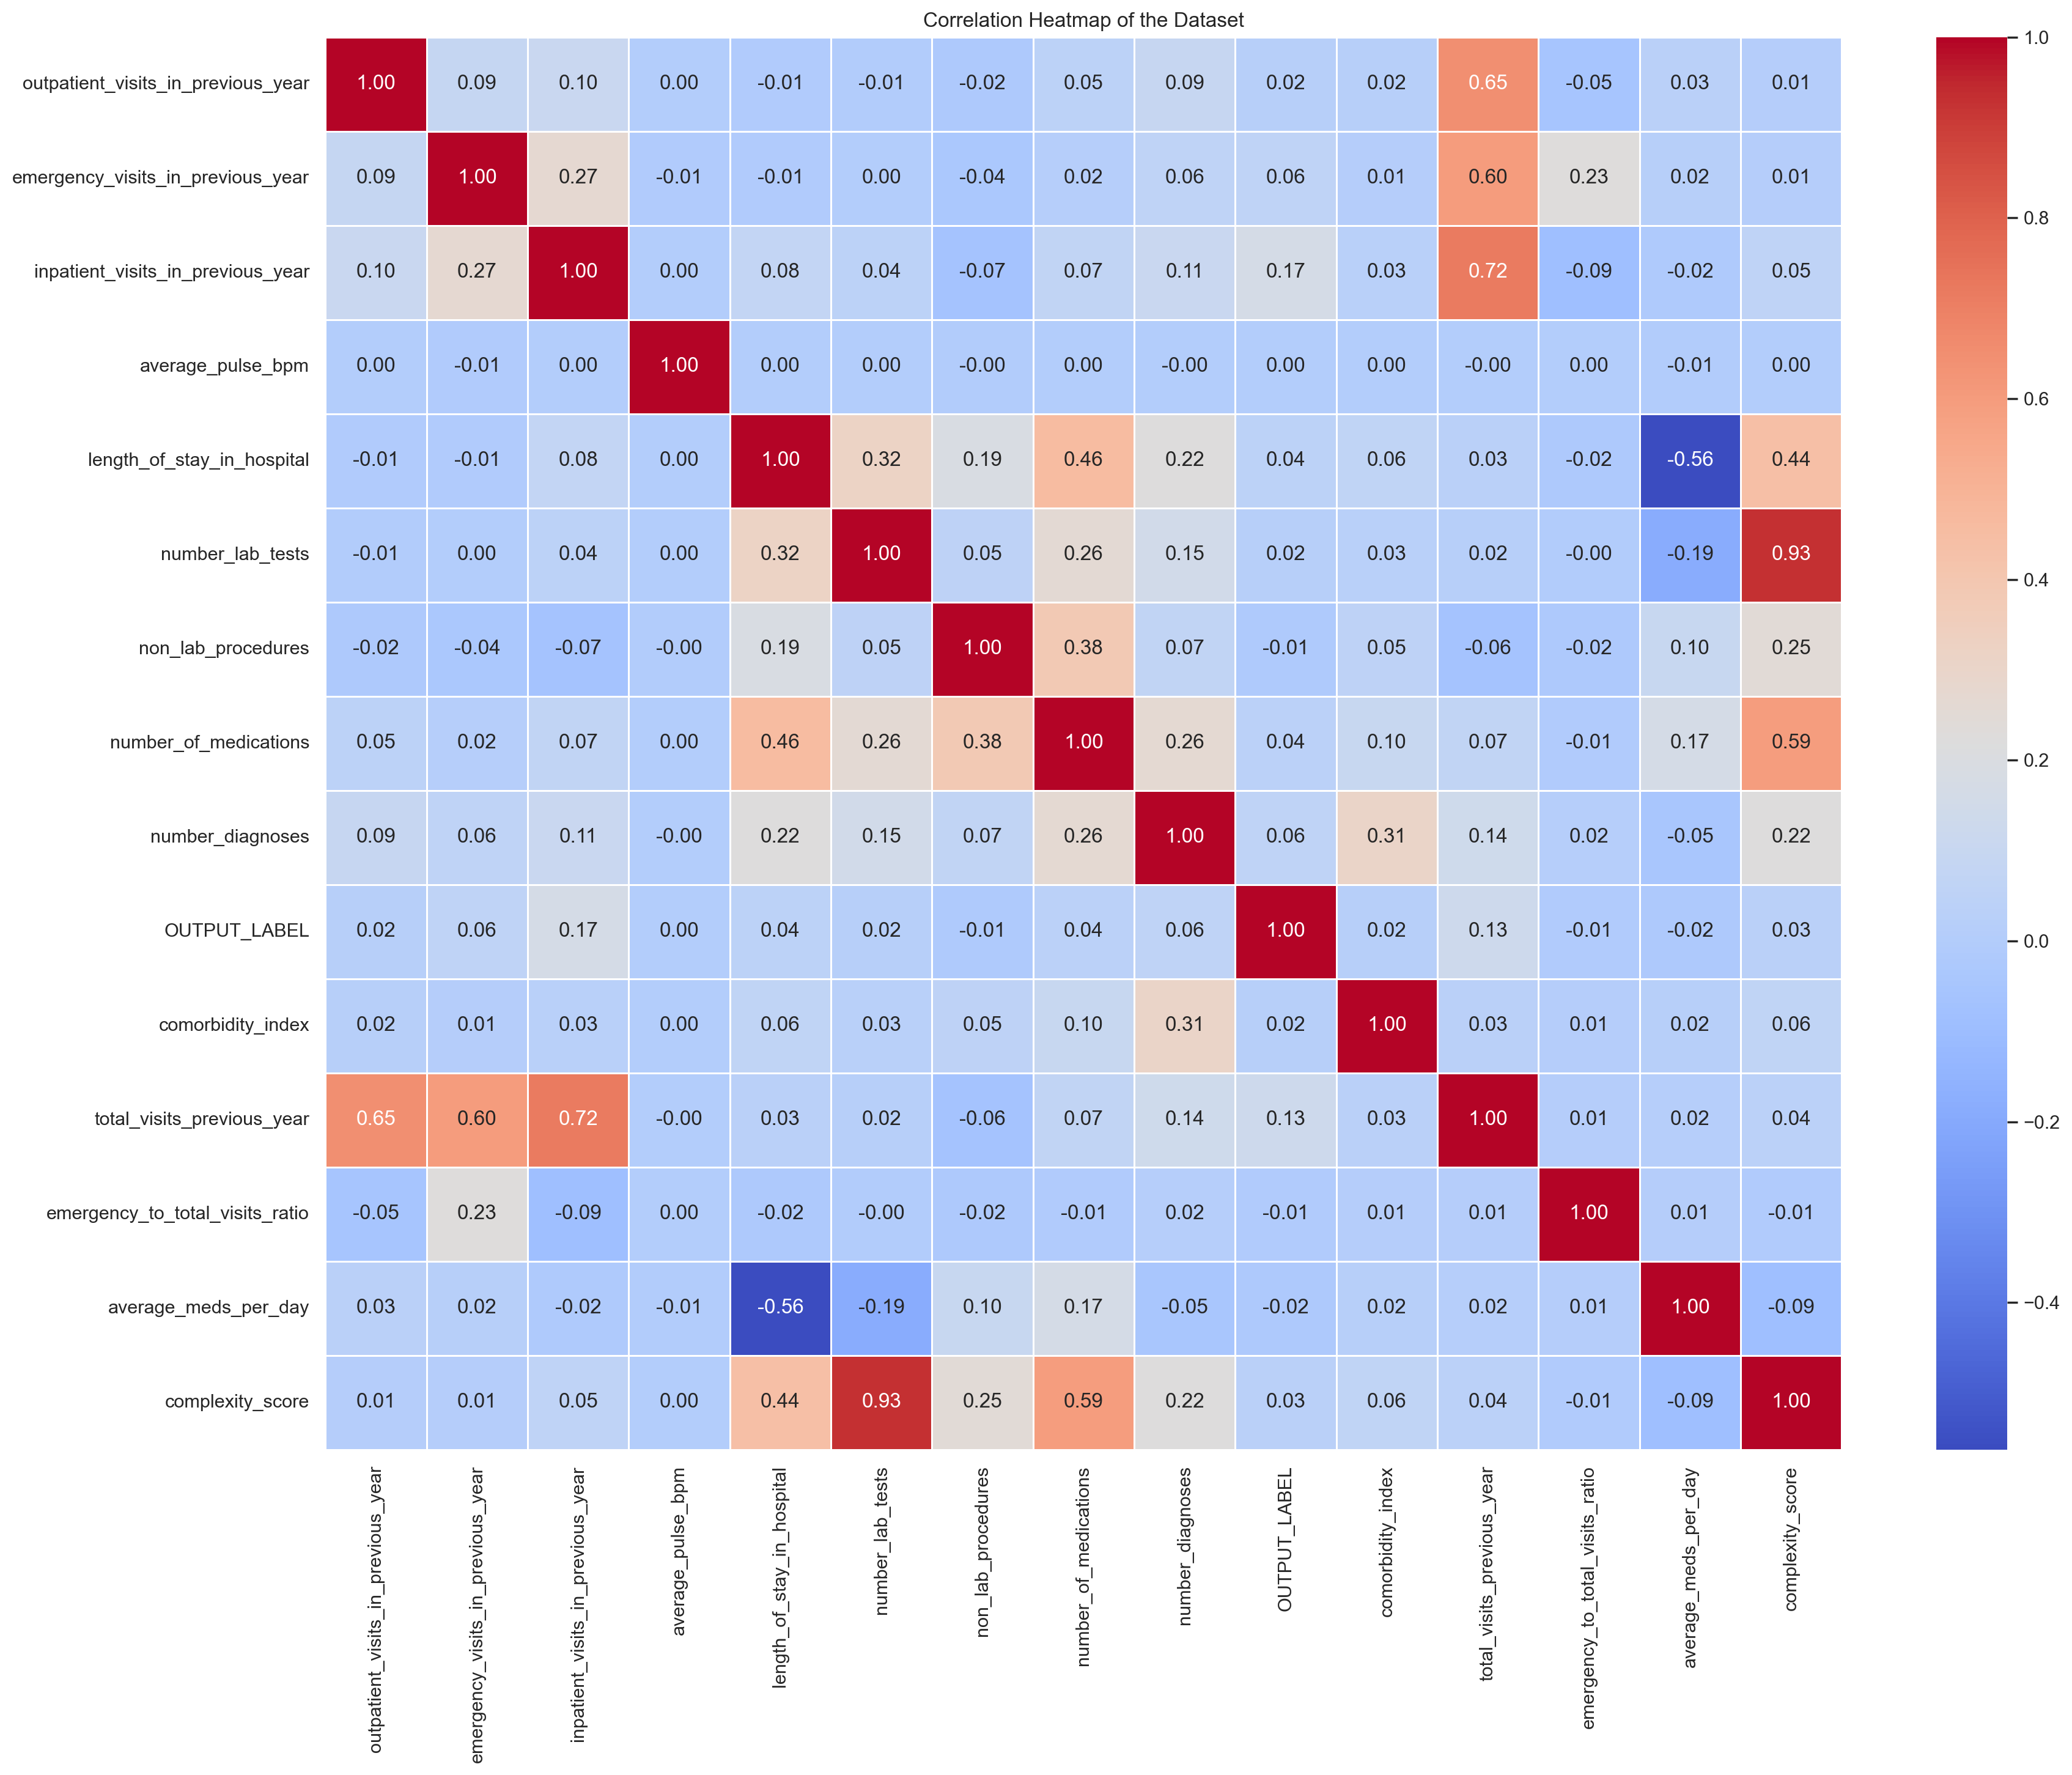

In [35]:
# Calculate the correlation matrix
corr = df.corr()

# Set up the figure size
plt.figure(figsize=(20, 15))

# Draw the heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Show the plot
plt.title('Correlation Heatmap of the Dataset')
plt.show()

In [36]:
# Drop number_lab_tests (similiar to complexity_score)
df.drop(columns='number_lab_tests', inplace=True)
df_test.drop(columns='number_lab_tests', inplace=True)

# ENCODING

In [37]:
df_cat = pd.get_dummies(df[cols_cat + cols_cat_num + ['medical_specialty']], drop_first=True)

# Create dummies for df_test
df_cat_test = pd.get_dummies(df_test[cols_cat + cols_cat_num + ['medical_specialty']], drop_first=True)

# Align columns
missing_cols = set(df_cat.columns) - set(df_cat_test.columns)
for c in missing_cols:
    df_cat_test[c] = 0

# Ensure the order of column in the test set is in the same order than in train set
df_cat_test = df_cat_test[df_cat.columns]

In [38]:
df_cat

race_Asian  race_Caucasian  race_Hispanic  race_Other  race_UNK  \
0               0               1              0           0         0   
1               0               0              0           0         0   
2               0               1              0           0         0   
3               0               0              0           0         0   
4               0               1              0           0         0   
...           ...             ...            ...         ...       ...   
71231           0               0              0           0         0   
71232           0               0              0           0         0   
71233           0               1              0           0         0   
71234           0               1              0           0         0   
71235           0               1              0           0         0   

       gender_Male  gender_Unknown/Invalid  glucose_test_result_>300  \
0                0                       0                         0   
1                1                       0                         0   
2                0                       0                         0   
3                1                       0                         0   
4                0                       0                         0   
...            ...                     ...                       ...   
71231            0                       0                         0   
71232            0                       0                         0   
71233            0                       0                         1   
71234            1                       0                         0   
71235            1                       0                         0   

       glucose_test_result_Norm  glucose_test_result_UNK  a1c_test_result_>8  \
0                             0                        1                   0   
1                             0                        1                   0   
2                             0                        1                   0   
3                             0                        1                   0   
4                             0                        1                   0   
...                         ...                      ...                 ...   
71231                         0                        1                   0   
71232                         0                        1                   0   
71233                         0                        0                   0   
71234                         0                        1                   0   
71235                         0                        1                   0   

       a1c_test_result_Norm  a1c_test_result_UNK  \
0                         0                    1   
1                         0                    1   
2                         0                    1   
3                         0                    1   
4                         0                    1   
...                     ...                  ...   
71231                     0                    0   
71232                     0                    0   
71233                     0                    1   
71234                     0                    1   
71235                     0                    1   

       change_in_meds_during_hospitalization_No  prescribed_diabetes_meds_Yes  \
0                                             1                             0   
1                                             1                             1   
2                                             0                             1   
3                                             1                             0   
4                                             1                             0   
...                                         ...                           ...   
71231                                         0                             1   
71232              

In [39]:
df_cat_test

race_Asian  race_Caucasian  race_Hispanic  race_Other  race_UNK  \
0               0               1              0           0         0   
1               0               1              0           0         0   
2               0               0              0           0         0   
3               0               1              0           0         0   
4               0               1              0           0         0   
...           ...             ...            ...         ...       ...   
30525           0               1              0           0         0   
30526           0               1              0           0         0   
30527           0               1              0           0         0   
30528           0               1              0           0         0   
30529           0               1              0           0         0   

       gender_Male  gender_Unknown/Invalid  glucose_test_result_>300  \
0                1                       0                         0   
1                1                       0                         1   
2                1                       0                         0   
3                1                       0                         0   
4                1                       0                         0   
...            ...                     ...                       ...   
30525            1                       0                         0   
30526            1                       0                         0   
30527            0                       0                         0   
30528            1                       0                         0   
30529            0                       0                         0   

       glucose_test_result_Norm  glucose_test_result_UNK  a1c_test_result_>8  \
0                             0                        1                   0   
1                             0                        0                   0   
2                             0                        1                   0   
3                             0                        1                   0   
4                             0                        1                   0   
...                         ...                      ...                 ...   
30525                         0                        1                   0   
30526                         0                        1                   0   
30527                         0                        1                   0   
30528                         0                        1                   0   
30529                         0                        1                   0   

       a1c_test_result_Norm  a1c_test_result_UNK  \
0                         0                    1   
1                         0                    1   
2                         0                    1   
3                         0                    1   
4                         0                    1   
...                     ...                  ...   
30525                     0                    1   
30526                     0                    1   
30527                     0                    1   
30528                     0                    0   
30529                     0                    1   

       change_in_meds_during_hospitalization_No  prescribed_diabetes_meds_Yes  \
0                                             1                             1   
1                                             1                             0   
2                                             1                             1   
3                                             0                             1   
4                                             1                             1   
...                                         ...                           ...   
30525                                         1                             0   
30526              

In [40]:
df = pd.concat([df,df_cat], axis = 1)

df_test = pd.concat([df_test,df_cat_test], axis = 1)

In [41]:
cols_all_cat = list(df_cat.columns)
cols_all_cat_test = list(df_cat_test.columns)

<hr>
<a class="anchor" id="import">
    
# 5. Extra Features
    
</a>

In [42]:
df[['age', 'weight']].head()

age weight
0  [70-80)    NaN
1  [50-60)    NaN
2  [60-70)    NaN
3  [60-70)    NaN
4  [70-80)    NaN

In [43]:
df.groupby('age').size()

age
[0-10)        104
[10-20)       473
[20-30)      1067
[30-40)      2529
[40-50)      6373
[50-60)     11296
[60-70)     14633
[70-80)     16873
[80-90)     11011
[90-100)     1739
dtype: int64

In [44]:
# Let's map these to 0-9 for the numerical data.

# remember age has nans
df['age'] = df['age'].fillna('UNK')

df_test['age'] = df_test['age'].fillna('UNK')



mode_age = df['age'].mode()[0]
df['age'] = df['age'].replace('UNK', mode_age)

mode_age_test = df_test['age'].mode()[0]
df_test['age'] = df_test['age'].replace('UNK', mode_age_test)

age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
df['age_group'] = df.age.replace(age_id)

df_test['age_group'] = df_test.age.replace(age_id)

In [45]:
# Now let's look at weight. Recall that this feature is not filled out very often.
df.weight.notnull().sum()

2197

In [46]:
# Instead of creating an ordinal feature that we did above, let's just create a variable to say if weight was filled out or not. The presence of a variable might be predictive regardless of the value.
df['has_weight'] = df.weight.notnull().astype('int')

df_test['has_weight'] = df_test.weight.notnull().astype('int')

In [47]:
cols_extra = ['age_group','has_weight', 'comorbidity_index', 'total_visits_previous_year', 'emergency_to_total_visits_ratio', 'average_meds_per_day', 'complexity_score']
cols_extra_test = ['age_group','has_weight', 'comorbidity_index', 'total_visits_previous_year', 'emergency_to_total_visits_ratio', 'average_meds_per_day', 'complexity_score']

<hr>
<a class="anchor" id="import">
    
# 6. Engineering Features Summary
    
</a>

In [48]:
print('Total number of features:', len(cols_num + cols_all_cat + cols_extra))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

Total number of features: 154
Numerical Features: 7
Categorical Features: 140
Extra features: 7


In [49]:
df[cols_num + cols_all_cat + cols_extra].isnull().sum().sort_values(ascending = False).head(10)

length_of_stay_in_hospital                                0
medical_specialty_Orthopedics-Reconstructive              0
medical_specialty_Neurophysiology                         0
medical_specialty_Obsterics&Gynecology-GynecologicOnco    0
medical_specialty_Obstetrics                              0
medical_specialty_ObstetricsandGynecology                 0
medical_specialty_Oncology                                0
medical_specialty_Ophthalmology                           0
medical_specialty_Orthopedics                             0
medical_specialty_Osteopath                               0
dtype: int64

In [50]:
col2use = cols_num + cols_all_cat + cols_extra
df_data = df[col2use + ['OUTPUT_LABEL']]

col2use_test = cols_num_test + cols_all_cat_test + cols_extra_test
df_data_test = df_test[col2use_test]

<hr>
<a class="anchor" id="import">
    
# 7. Building Training/Validation/Test Samples
    
</a>

In [51]:
df_data.columns

Index(['length_of_stay_in_hospital', 'non_lab_procedures',
       'number_of_medications', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'number_diagnoses', 'race_Asian',
       'race_Caucasian', 'race_Hispanic',
       ...
       'medical_specialty_UNK', 'medical_specialty_Urology', 'age_group',
       'has_weight', 'comorbidity_index', 'total_visits_previous_year',
       'emergency_to_total_visits_ratio', 'average_meds_per_day',
       'complexity_score', 'OUTPUT_LABEL'],
      dtype='object', length=155)

In [52]:
df_data_test.columns

Index(['length_of_stay_in_hospital', 'non_lab_procedures',
       'number_of_medications', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'number_diagnoses', 'race_Asian',
       'race_Caucasian', 'race_Hispanic',
       ...
       'medical_specialty_SurgicalSpecialty', 'medical_specialty_UNK',
       'medical_specialty_Urology', 'age_group', 'has_weight',
       'comorbidity_index', 'total_visits_previous_year',
       'emergency_to_total_visits_ratio', 'average_meds_per_day',
       'complexity_score'],
      dtype='object', length=154)

In [53]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

In [54]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.100


In [55]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

In [56]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

In [57]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

Test prevalence(n = 3479):0.117
Valid prevalence(n = 3479):0.116
Train all prevalence(n = 62617):0.114


In [58]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 69575)


In [59]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 14224):0.500


In [60]:
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (62617, 154)
Training shapes: (14224, 154) (14224,)
Validation shapes: (3479, 154) (3479,)


In [61]:
scaler = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

In [62]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

<hr>
<a class="anchor" id="import">
    
# 8. Model Selection
    
</a>

In [63]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

In [64]:
thresh = 0.5

<a class="anchor" id="CatVarDist">

## 8.1. K nearest neighbors (KNN)

</a>

In [65]:
# k-nearest neighbors

knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [66]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.655
accuracy:0.604
recall:0.509
precision:0.629
specificity:0.665
prevalence:0.500
 
Validation:
AUC:0.644
accuracy:0.671
recall:0.504
precision:0.177
specificity:0.651
prevalence:0.116
 


In [67]:
knn_predict = knn.predict(X_valid_tf)

# Compute the confusion matrix
cm_gb = confusion_matrix(y_valid, knn_predict)
print(cm_gb)

[[2131  945]
 [ 200  203]]


<a class="anchor" id="CatVarDist">

## 8.2. Random Forest

</a>

In [68]:
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [69]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.687
accuracy:0.634
recall:0.646
precision:0.631
specificity:0.623
prevalence:0.500
 
Validation:
AUC:0.687
accuracy:0.603
recall:0.682
precision:0.180
specificity:0.593
prevalence:0.116
 


In [70]:
rf_predict = rf.predict(X_valid)

# Compute the confusion matrix
cm_gb = confusion_matrix(y_valid, rf_predict)
print(cm_gb)

[[   0 3076]
 [   0  403]]


<a class="anchor" id="CatVarDist">

## 8.3. Logistic Regression last(0.2665)

</a>

In [71]:
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [72]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.672
accuracy:0.623
recall:0.558
precision:0.641
specificity:0.687
prevalence:0.500
 
Validation:
AUC:0.682
accuracy:0.666
recall:0.598
precision:0.194
specificity:0.675
prevalence:0.116
 


In [73]:
lr_predict = lr.predict(X_valid)

# Compute the confusion matrix
cm_gb = confusion_matrix(y_valid, lr_predict)
print(cm_gb)

[[   1 3075]
 [   0  403]]


<a class="anchor" id="CatVarDist">

## 8.4. Stochastic Gradient Descent

</a>

In [74]:
sgdc=SGDClassifier(loss = 'log_loss',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

SGDClassifier(alpha=0.1, loss='log_loss', random_state=42)

In [75]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.670
accuracy:0.619
recall:0.556
precision:0.636
specificity:0.682
prevalence:0.500
 
Validation:
AUC:0.683
accuracy:0.664
recall:0.591
precision:0.191
specificity:0.673
prevalence:0.116
 


In [76]:
sgdc_predict = sgdc.predict(X_valid)

# Compute the confusion matrix
cm_gb = confusion_matrix(y_valid, sgdc_predict)
print(cm_gb)

[[   1 3075]
 [   0  403]]


<a class="anchor" id="CatVarDist">

## 8.5. Naive Bayes

</a>

In [77]:
nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB()

In [78]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_train,y_train_preds, thresh)

Naive Bayes
Training:
AUC:0.522
accuracy:0.514
recall:0.975
precision:0.507
specificity:0.054
prevalence:0.500
 
Validation:
AUC:0.522
accuracy:0.514
recall:0.975
precision:0.507
specificity:0.054
prevalence:0.500
 


In [79]:
nb_predict = nb.predict(X_valid)

# Compute the confusion matrix
cm_gb = confusion_matrix(y_valid, nb_predict)
print(cm_gb)

[[3075    1]
 [ 403    0]]


<a class="anchor" id="CatVarDist">

## 8.6. Decision Tree Classifier

</a>

In [80]:
tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [81]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_train,y_train_preds, thresh)

Decision Tree
Training:
AUC:0.747
accuracy:0.668
recall:0.648
precision:0.674
specificity:0.683
prevalence:0.500
 
Validation:
AUC:0.747
accuracy:0.668
recall:0.648
precision:0.674
specificity:0.683
prevalence:0.500
 


In [82]:
tree_predict = tree.predict(X_valid)

# Compute the confusion matrix
cm_gb = confusion_matrix(y_valid, tree_predict)
print(cm_gb)

[[ 253 2823]
 [  63  340]]


<a class="anchor" id="CatVarDist">

## 8.7. Gradient Boosting Classifier

</a>

In [83]:
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [84]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_train,y_train_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.777
accuracy:0.699
recall:0.686
precision:0.704
specificity:0.711
prevalence:0.500
 
Validation:
AUC:0.777
accuracy:0.699
recall:0.686
precision:0.704
specificity:0.711
prevalence:0.500
 


In [85]:
gbc_predict = gbc.predict(X_valid)

# Compute the confusion matrix
cm_gb = confusion_matrix(y_valid, gbc_predict)
print(cm_gb)

[[2009 1067]
 [ 259  144]]


<hr>
<a class="anchor" id="import">
    
# 9. Analyze results baseline models
    
</a>

In [381]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*7,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_valid_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_valid_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_train_specificity,gbc_valid_specificity]})

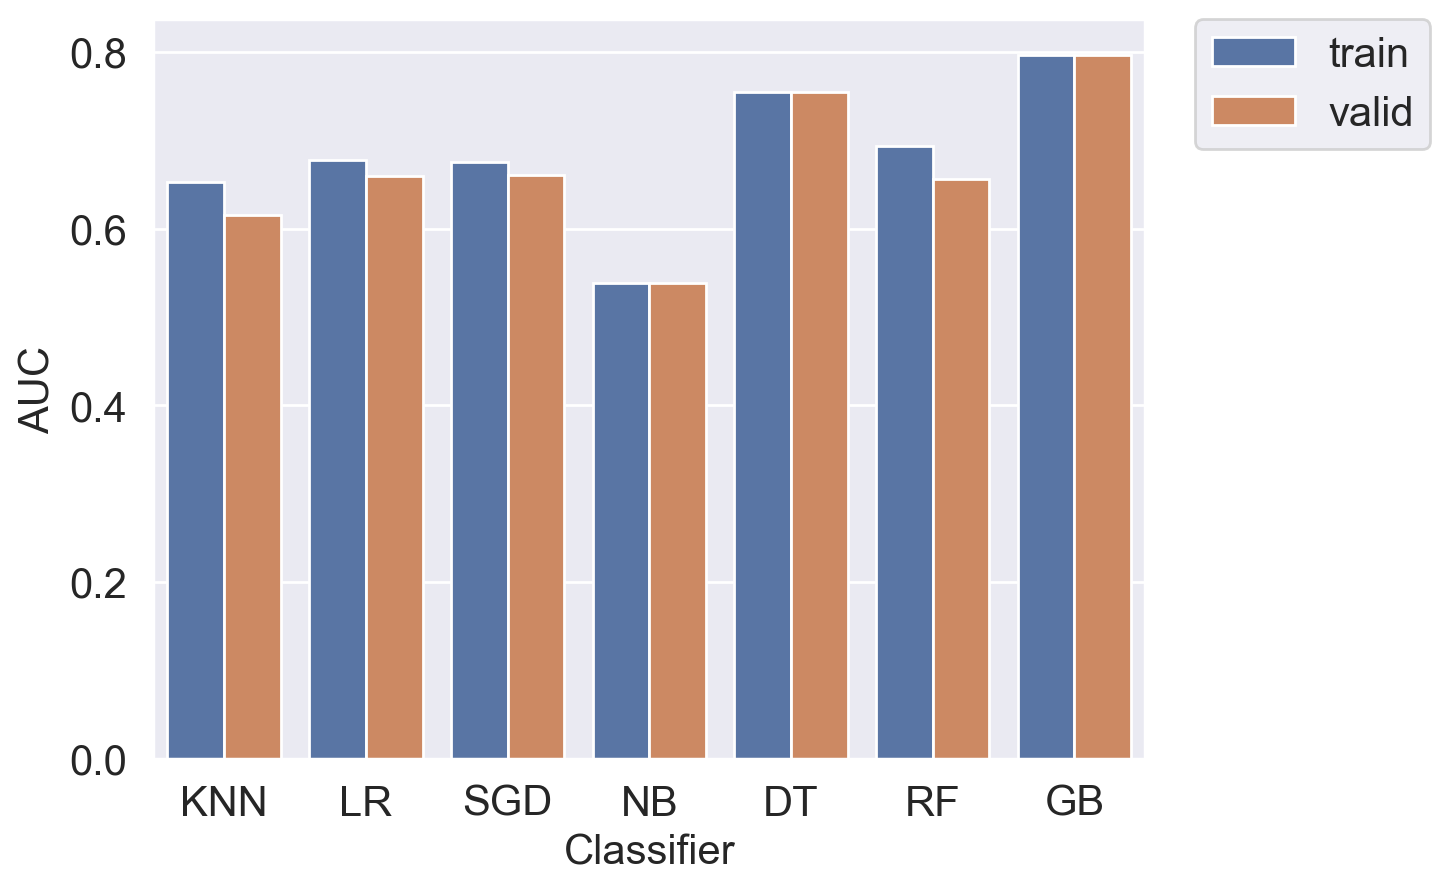

In [384]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

<hr>
<a class="anchor" id="import">
    
# 10. Model Selection: Learning Curve
    
</a>

In [389]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

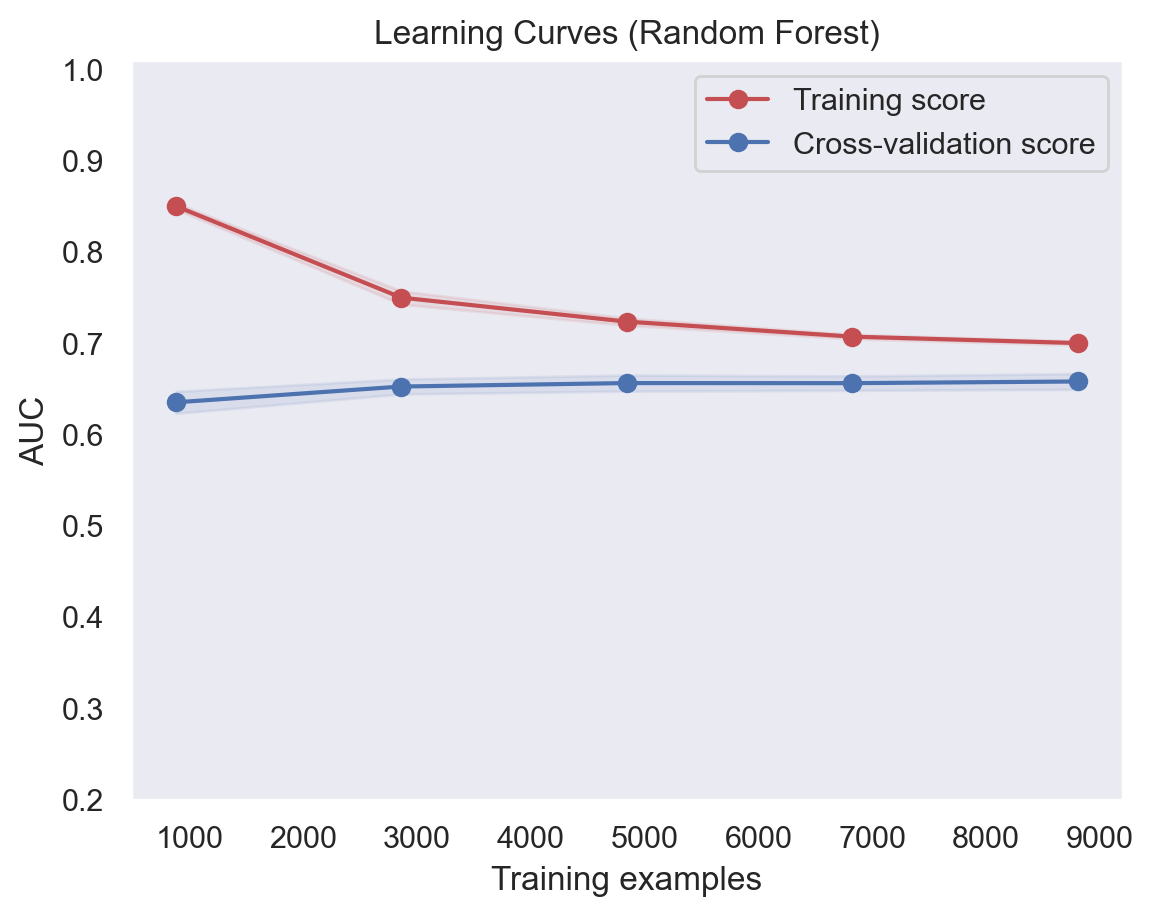

In [390]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 6, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

<hr>
<a class="anchor" id="import">
    
# 11. Feature Importance
    
</a>

<a class="anchor" id="CatVarDist">

## 11.1. Feature Importance: Logistic regression

</a>

In [392]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [393]:
feature_importances.head()

importance
inpatient_visits_in_previous_year                     0.366062
medical_specialty_Hematology                          0.187543
discharge_disposition_Discharged/transferred to...    0.161741
discharge_disposition_Discharged/transferred to...    0.142229
number_diagnoses                                      0.101935

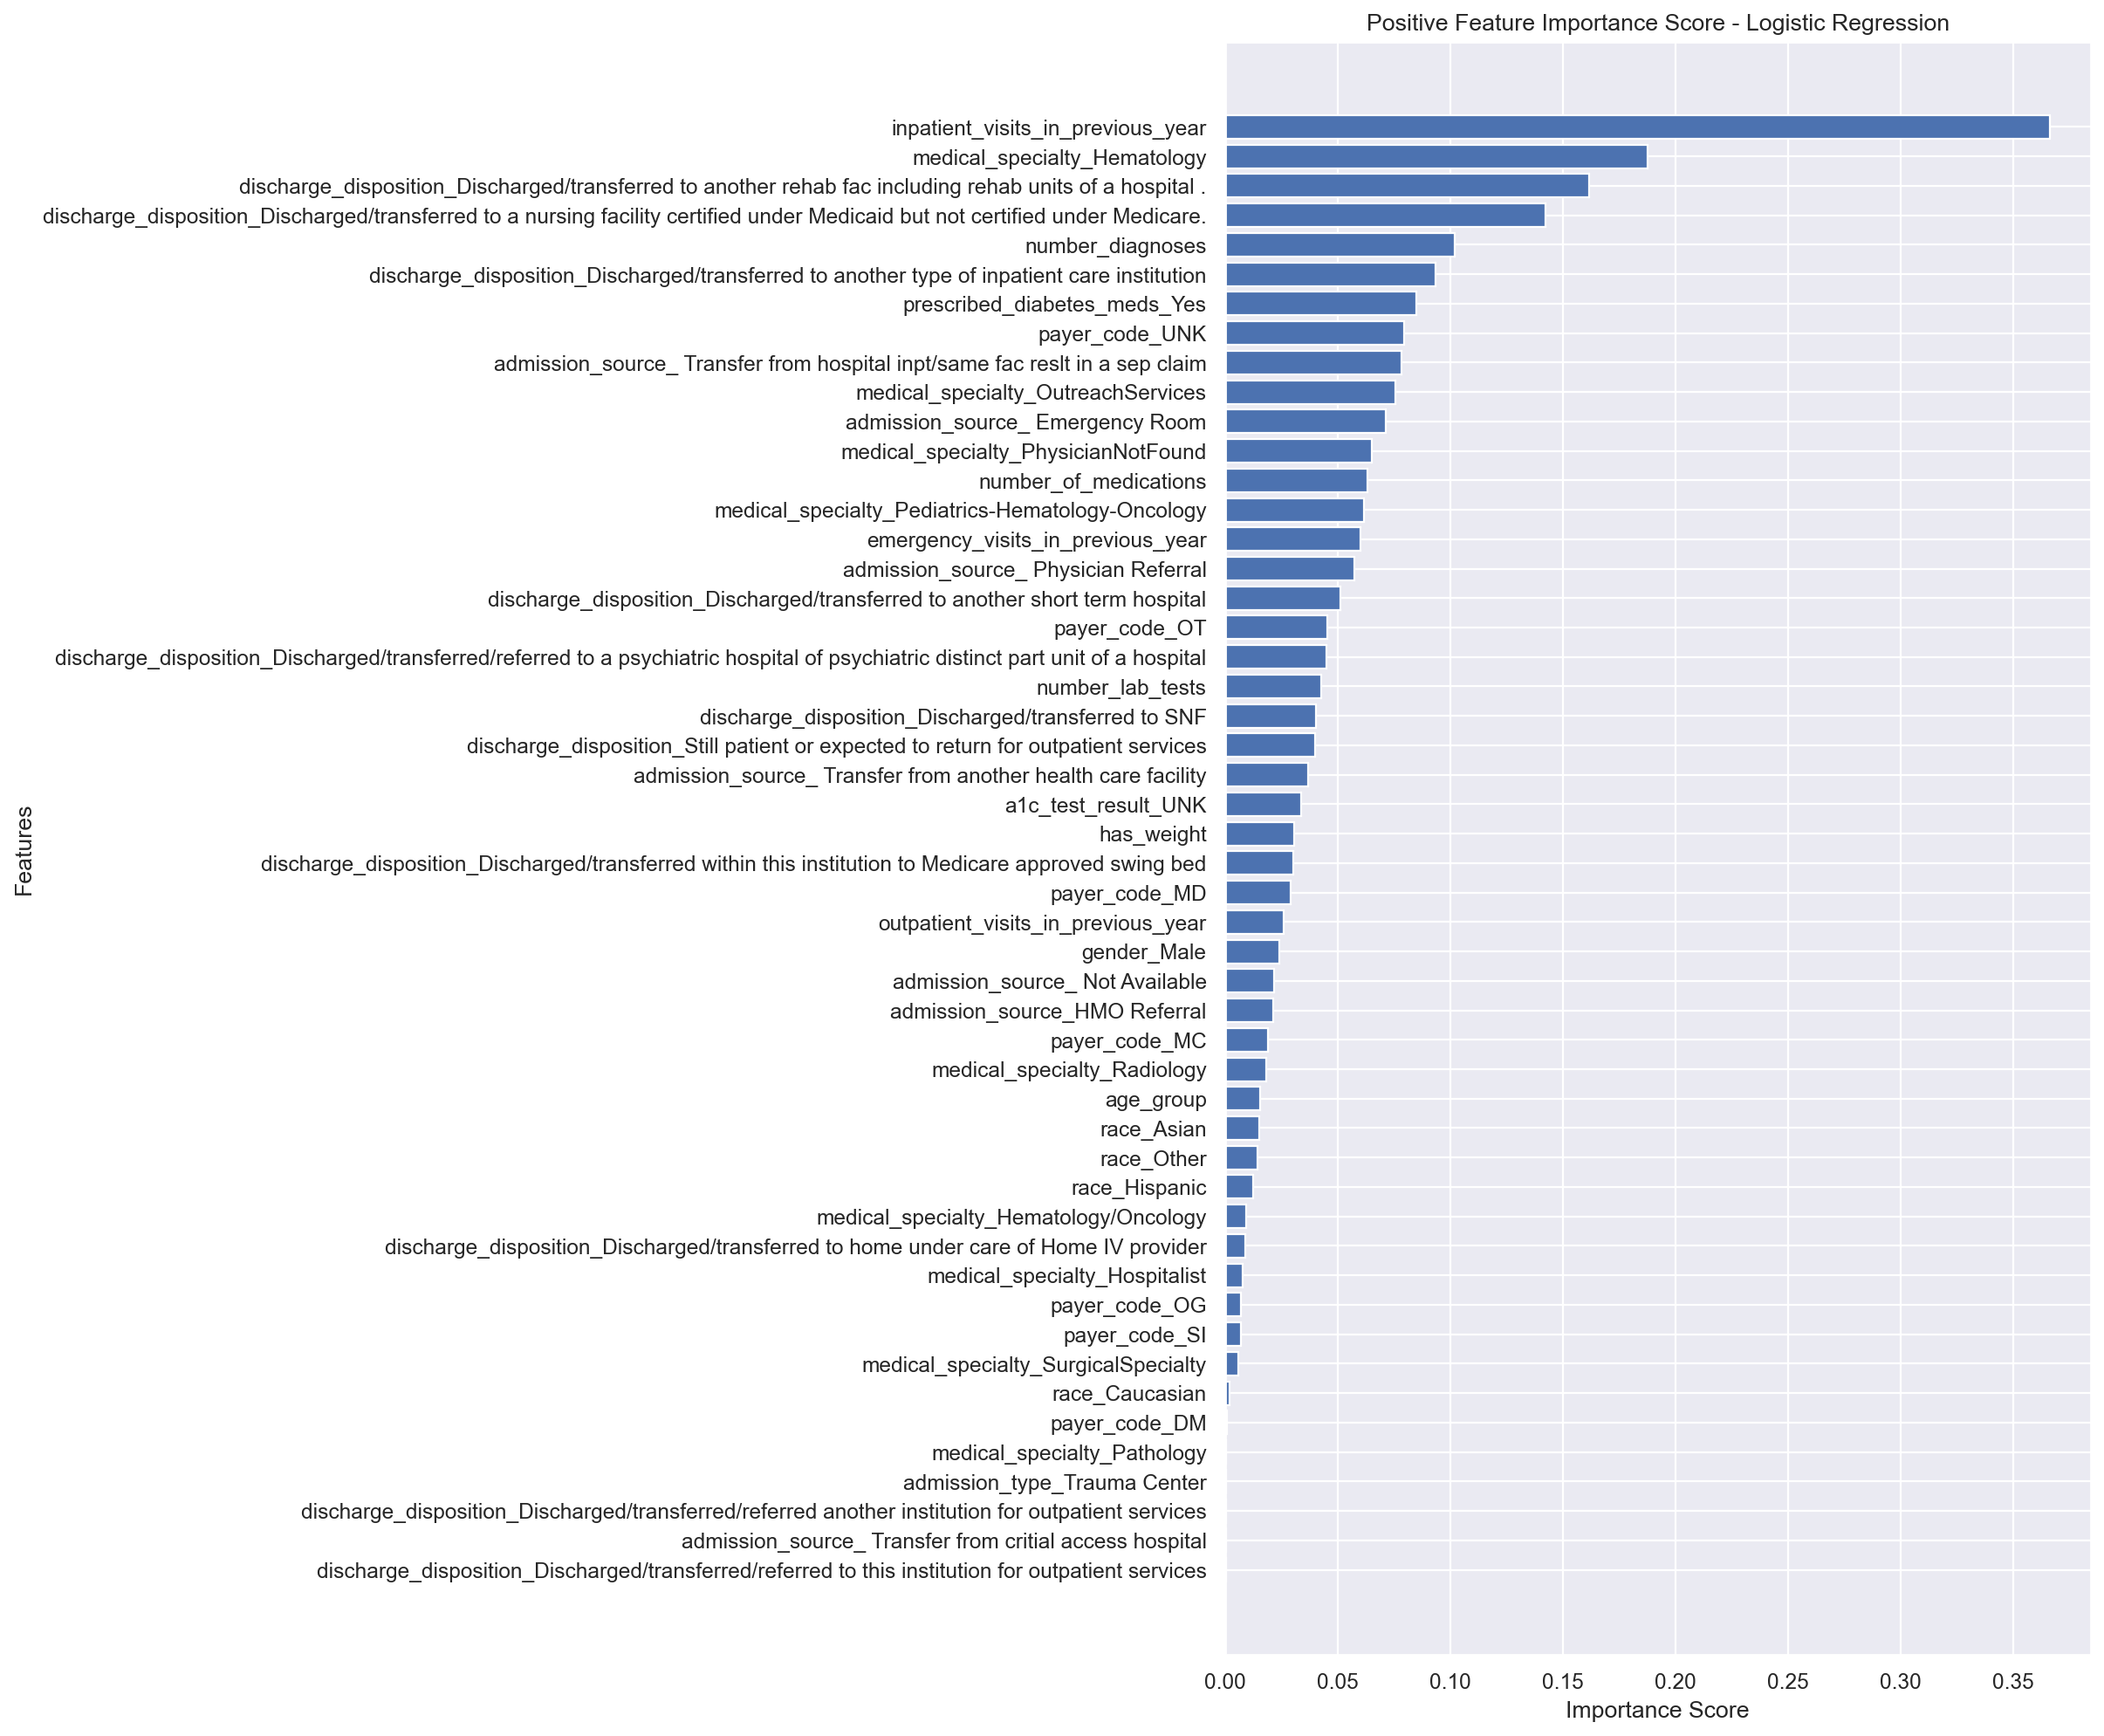

In [394]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

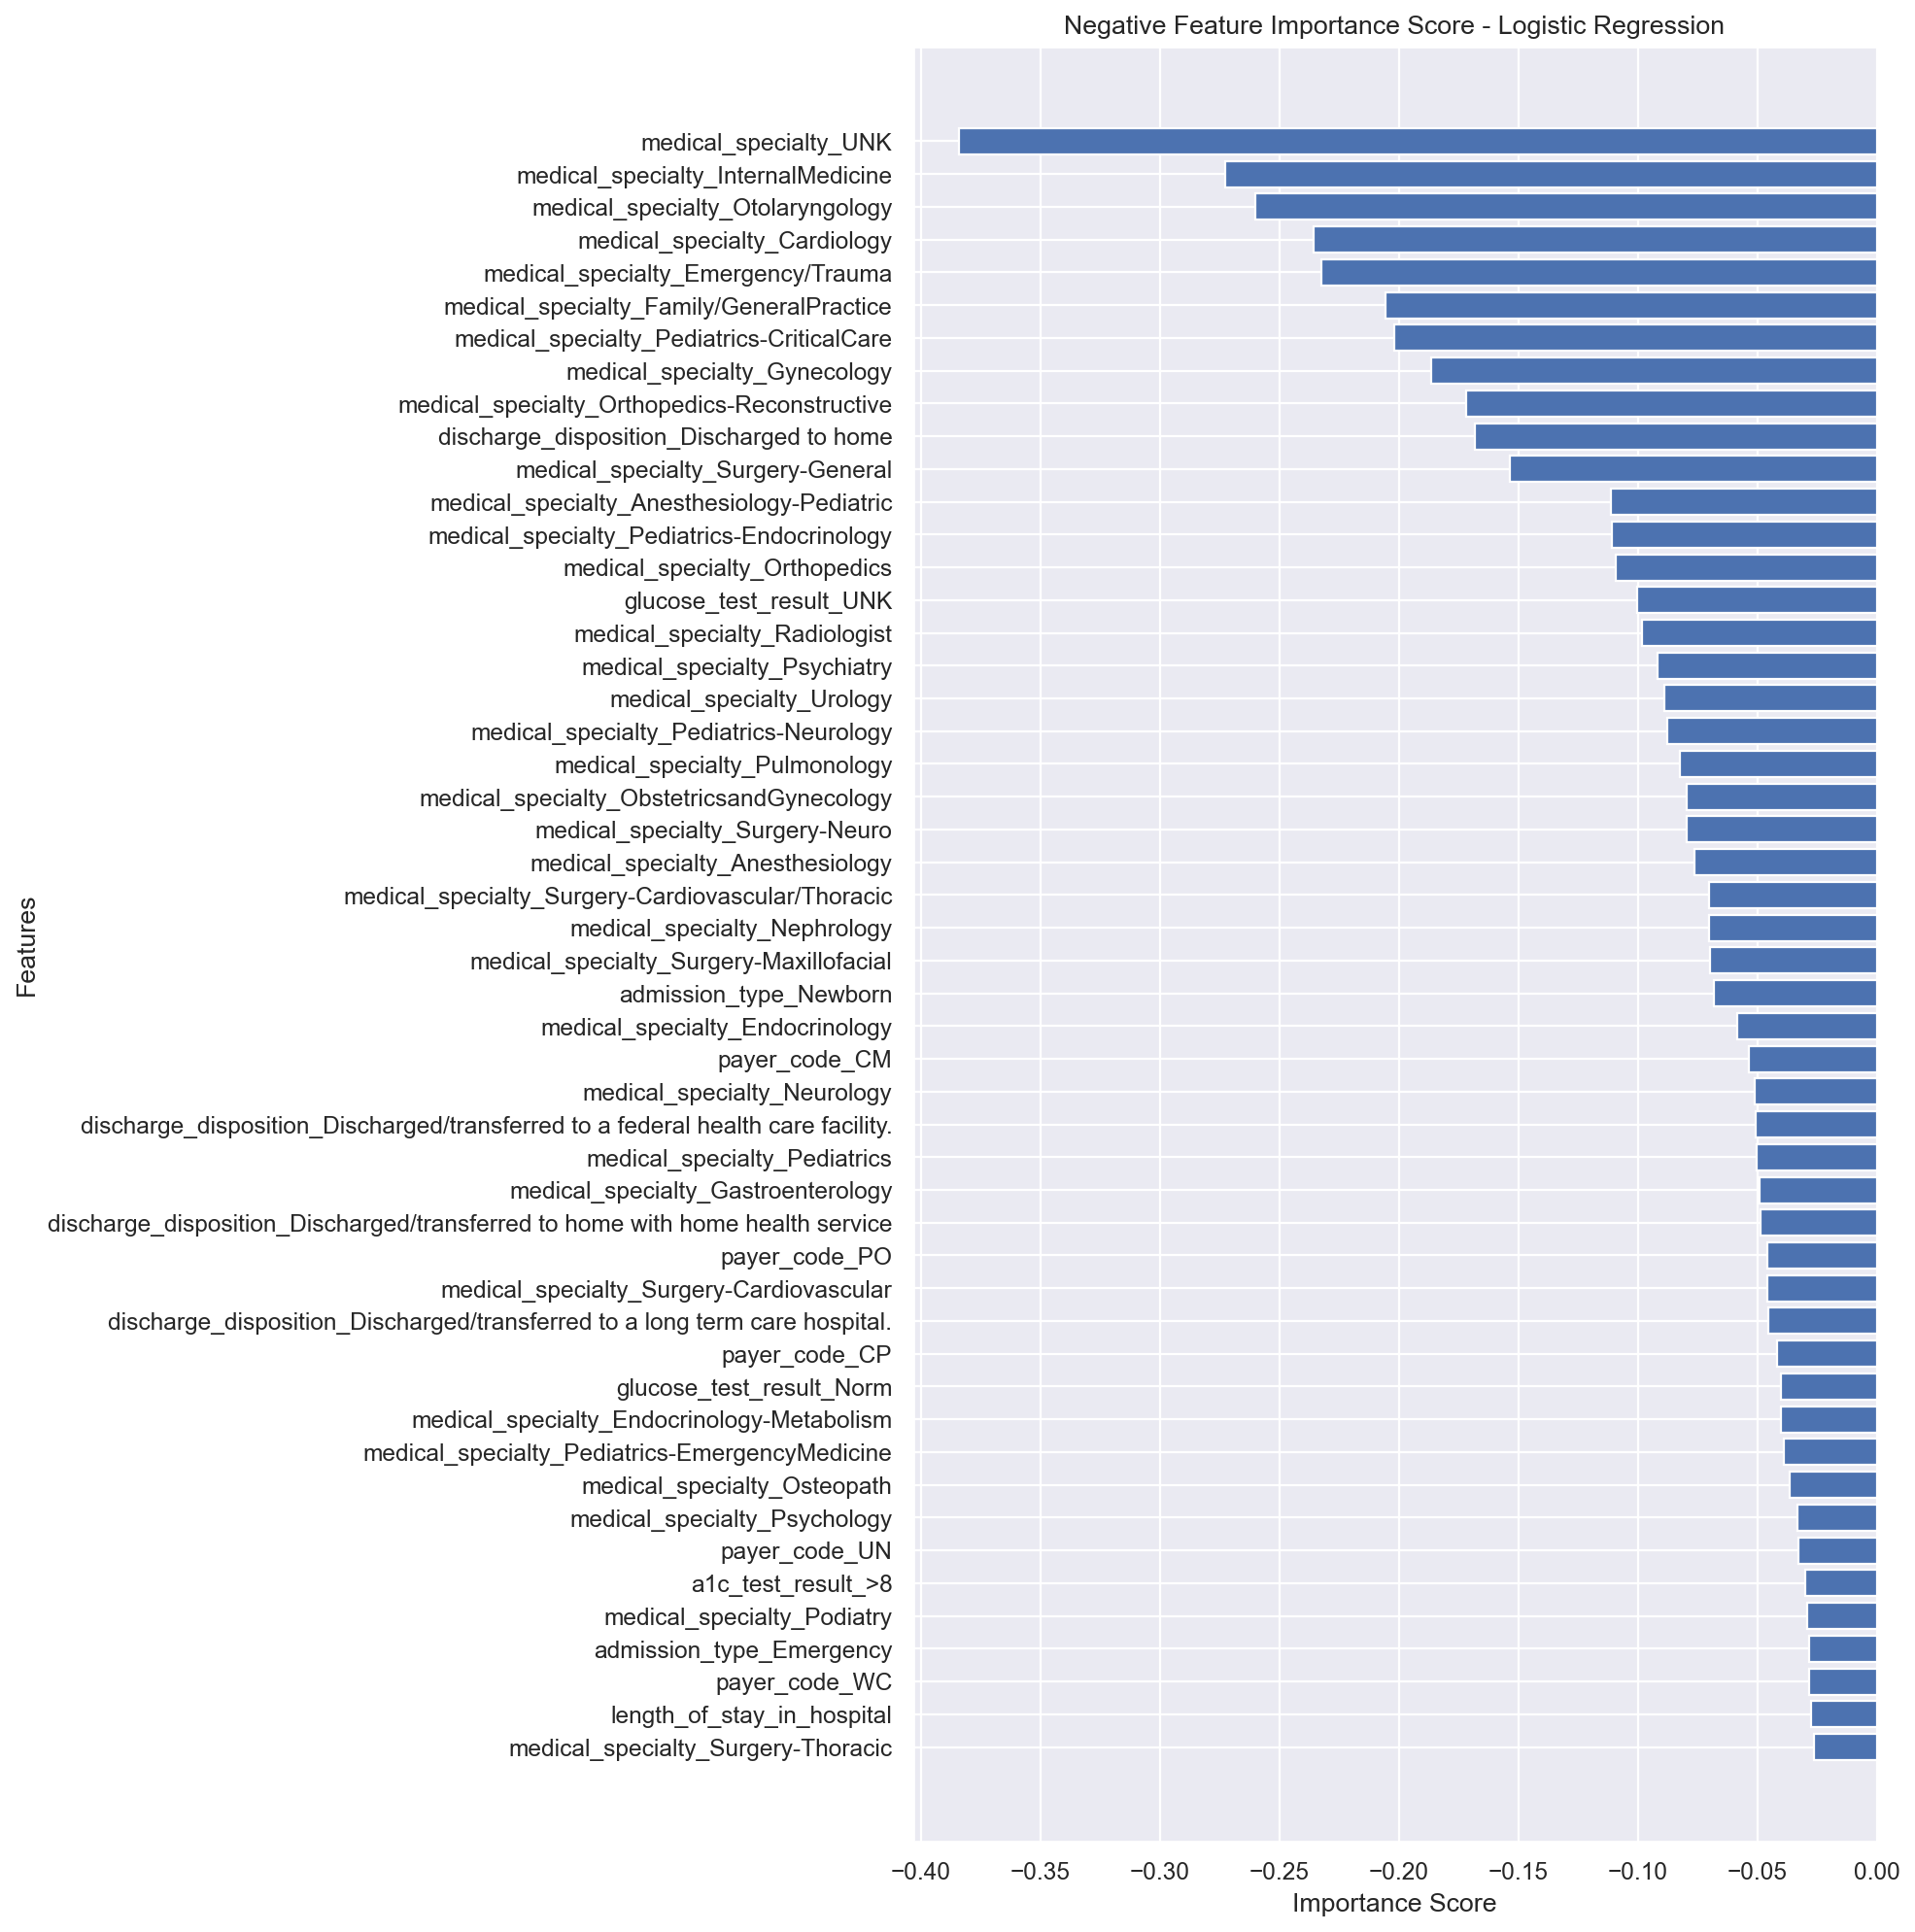

In [395]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

<a class="anchor" id="CatVarDist">

## 11.2. Feature Importance: random forest

</a>

In [396]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [398]:
feature_importances.head()

importance
inpatient_visits_in_previous_year           0.253055
discharge_disposition_Discharged to home    0.107336
number_of_medications                       0.072575
emergency_visits_in_previous_year           0.069889
number_diagnoses                            0.059411

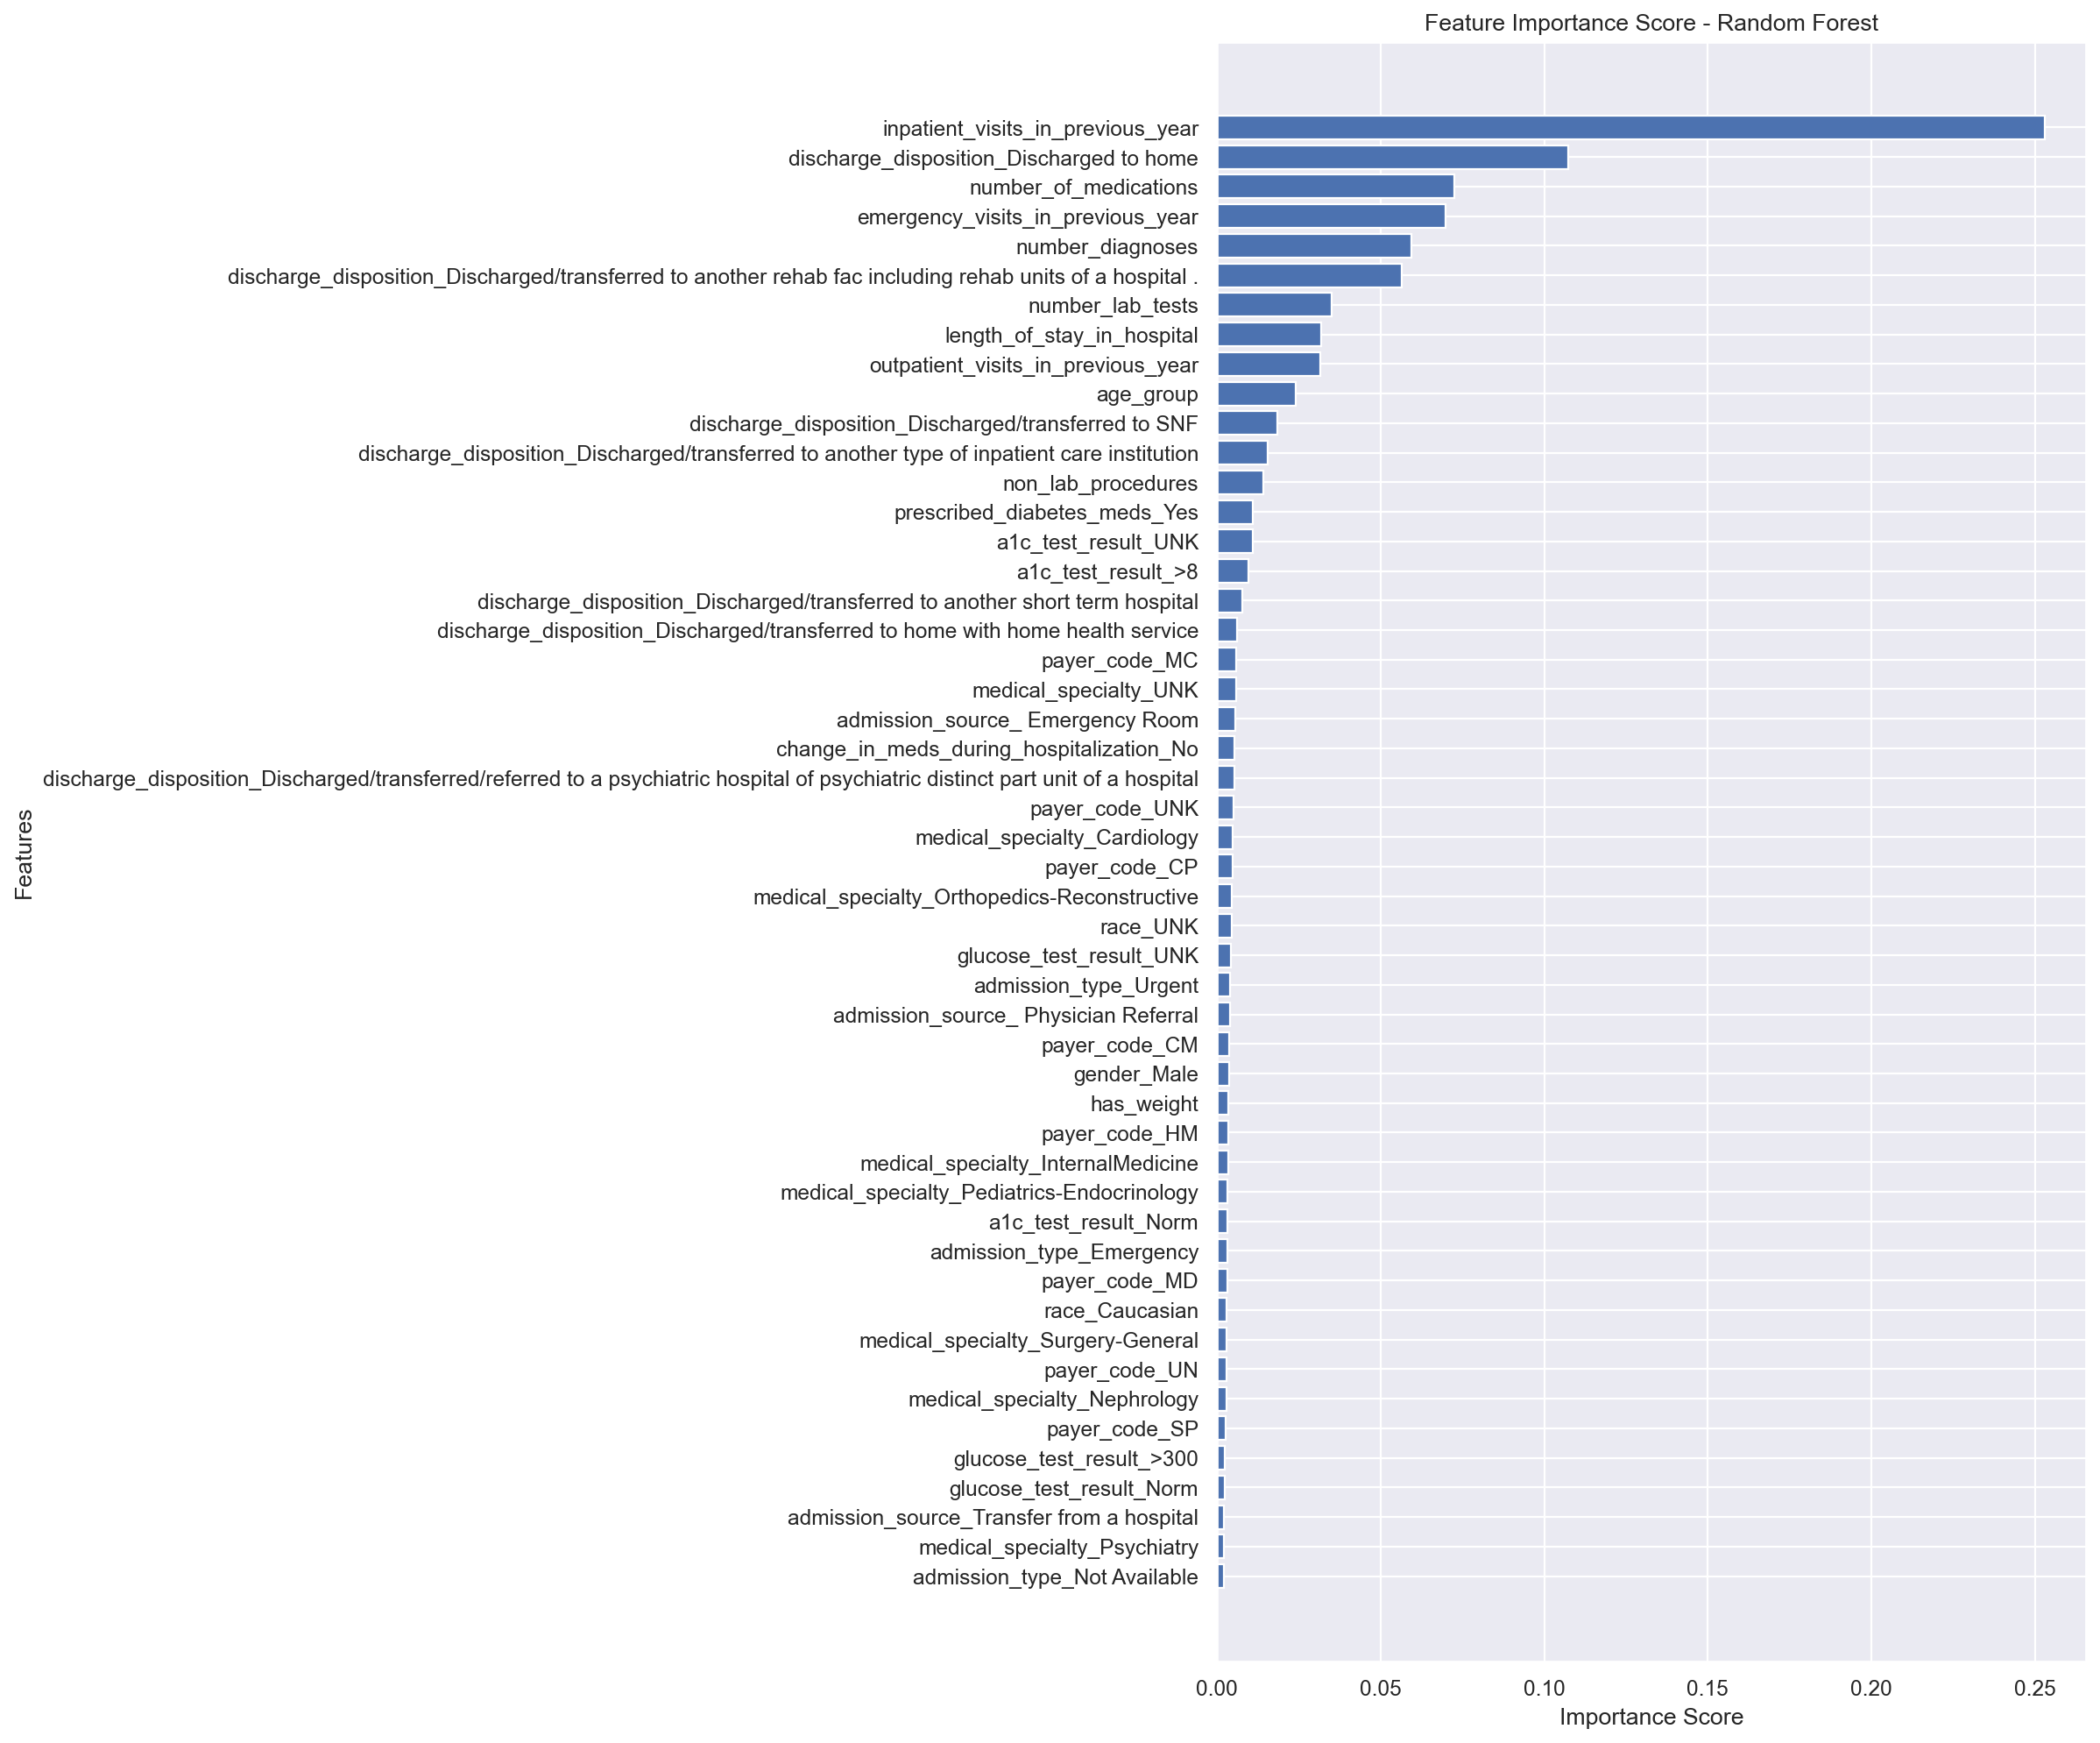

In [399]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

# Submit Kaggle

In [91]:
X_kaggle = df_data_test[col2use_test].values

scaler_kaggle = StandardScaler()
scaler_kaggle.fit(X_kaggle)

X_kaggle_tf = scaler_kaggle.transform(X_kaggle)

kaggle_predict = gbc.predict(X_kaggle_tf)

mapping = np.array(['No', 'Yes'])
kaggle_predict = mapping[kaggle_predict]

df_result = pd.DataFrame({
    'encounter_id': encounter_ids,
    'readmitted_binary': kaggle_predict
})

df_result

encounter_id readmitted_binary
0            499502                No
1            447319                No
2            309126                No
3            181183                No
4            359339                No
...             ...               ...
30525        451150                No
30526        549298               Yes
30527        327586               Yes
30528        351214               Yes
30529        914270               Yes

[30530 rows x 2 columns]

In [92]:
df_result.to_csv('Group09__Version07.csv', index=False)